# Lesson 1 - Plant Seedling port from fastai v0.7 to lesson1 of fastai v1 

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [32]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [33]:
from fastai import *
from fastai.vision import *

In [34]:
import os
duration = 1  # second
freq = 440  # Hz
def beep():
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))
  


## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [4]:
# See how many devices are around
torch.cuda.device_count()


2

In [5]:
# Check which device you are on
torch.cuda.current_device()


0

In [6]:
# Set it to a particular device
torch.cuda.set_device(1)


In [7]:
# Check which device you are on
torch.cuda.current_device()

1

In [8]:
doc(untar_data)

untar_data [source] untar_data ( url : str , fname : PathOrStr = None , dest : PathOrStr = None , data = True ) 
 
 Download url if doesn't exist to fname and un-tgz to folder dest 
 Show in docs

In [9]:
path = Path('/home/haider/.fastai/data/plant_seedlings')

In [10]:
path

PosixPath('/home/haider/.fastai/data/plant_seedlings')

In [11]:
path.ls()

[PosixPath('/home/haider/.fastai/data/plant_seedlings/train_subdir'),
 PosixPath('/home/haider/.fastai/data/plant_seedlings/testing_from_www'),
 PosixPath('/home/haider/.fastai/data/plant_seedlings/labels_with_suffix.csv'),
 PosixPath('/home/haider/.fastai/data/plant_seedlings/sample_submission.csv'),
 PosixPath('/home/haider/.fastai/data/plant_seedlings/labels.csv'),
 PosixPath('/home/haider/.fastai/data/plant_seedlings/tmp'),
 PosixPath('/home/haider/.fastai/data/plant_seedlings/test'),
 PosixPath('/home/haider/.fastai/data/plant_seedlings/labels_with_only_one_word_without_separation.csv'),
 PosixPath('/home/haider/.fastai/data/plant_seedlings/models'),
 PosixPath('/home/haider/.fastai/data/plant_seedlings/subm'),
 PosixPath('/home/haider/.fastai/data/plant_seedlings/train')]

In [12]:
path_train = path/'train'
path_test = path/'test'
path_labels = path/'labels_with_only_one_word_without_separation.csv'


The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [13]:
fnames = get_image_files(path_train)
fnames[:5]

[PosixPath('/home/haider/.fastai/data/plant_seedlings/train/1d9676402.png'),
 PosixPath('/home/haider/.fastai/data/plant_seedlings/train/5112e0b90.png'),
 PosixPath('/home/haider/.fastai/data/plant_seedlings/train/115808876.png'),
 PosixPath('/home/haider/.fastai/data/plant_seedlings/train/fa55f4be4.png'),
 PosixPath('/home/haider/.fastai/data/plant_seedlings/train/ea31723d5.png')]

In [14]:
doc(ImageDataBunch.from_csv)

from_csv [source] from_csv ( path : PathOrStr , folder : PathOrStr = '.' , sep = None , csv_labels : PathOrStr = 'labels.csv' , valid_pct : float = 0.2 , fn_col : int = 0 , label_col : int = 1 , test : Union [ Path , str , NoneType ]= None , suffix : str = None , header : Union [ int , str , NoneType ]= 'infer' , kwargs : Any ) → ImageDataBunch 
 
 Create from a csv file. 
 Show in docs

In [15]:
#  this is to fix the random split of train/valid in the ImageDataBunch method 
# (otherwise if I repeat ImageDataBunch after after an already trained model it will make validation on something it have seen before)
np.random.seed(2)
 

In [16]:
data = ImageDataBunch.from_csv(path=path_train, ds_tfms=get_transforms(), size=224, csv_labels=path_labels,test=path_test )
data.normalize(imagenet_stats)

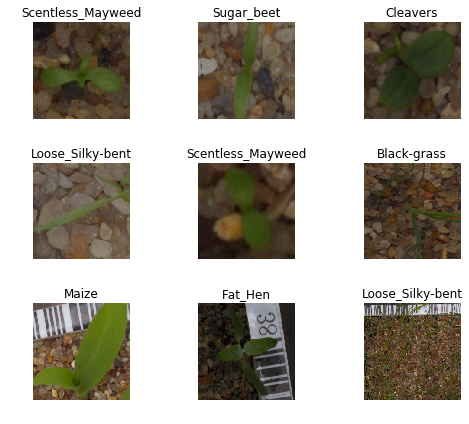

In [17]:
data.show_batch(rows=3, figsize=(7,6))

In [18]:
print(data.classes)
len(data.classes),data.c

['Black-grass', 'Charlock', 'Cleavers', 'Common_Chickweed', 'Common_wheat', 'Fat_Hen', 'Loose_Silky-bent', 'Maize', 'Scentless_Mayweed', 'Shepherds_Purse', 'Small-flowered_Cranesbill', 'Sugar_beet']


(12, 12)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 ouptuts).

We will train for 4 epochs (4 cycles through all our data).

In [19]:
# learn = ConvLearner(data, models.resnet34, metrics=error_rate)
# https://forums.fast.ai/t/developer-chat/22363/350?u=hayder78
# ConvLearner ctor is replaced by a function called create_cnn
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [20]:
learn.fit_one_cycle(4)

Total time: 07:11
epoch  train_loss  valid_loss  error_rate
1      1.652372    0.655504    0.214815    (01:49)
2      0.844776    0.359616    0.121693    (01:47)
3      0.525103    0.277379    0.094180    (01:47)
4      0.372150    0.270609    0.086772    (01:47)



In [21]:
learn.save('stage-1-coursev3')

In [22]:
learn.load('stage-1-coursev3')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

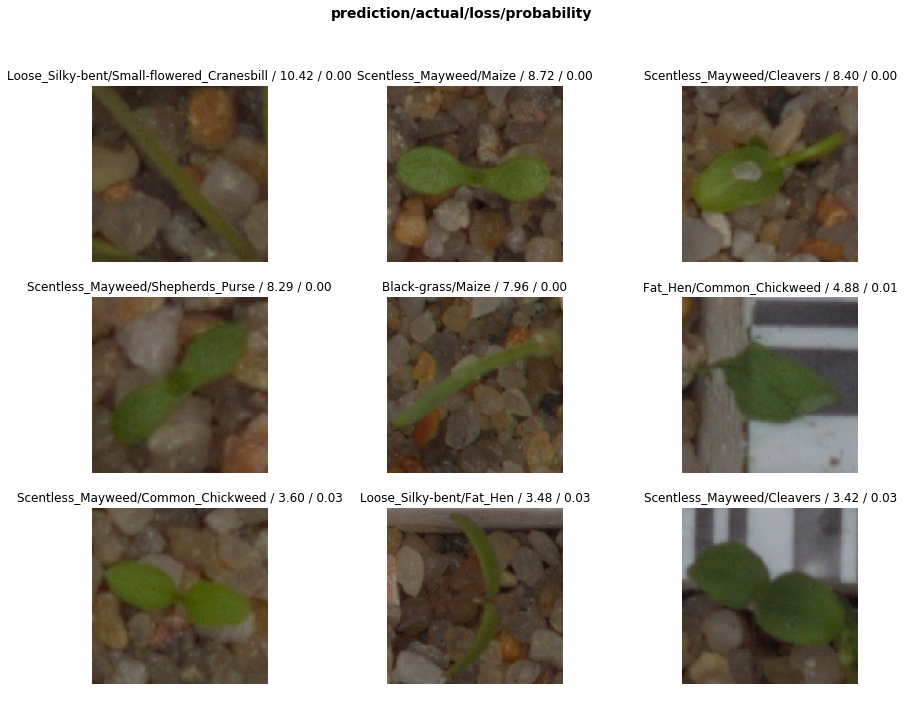

In [24]:
interp.plot_top_losses(9, figsize=(15,11))

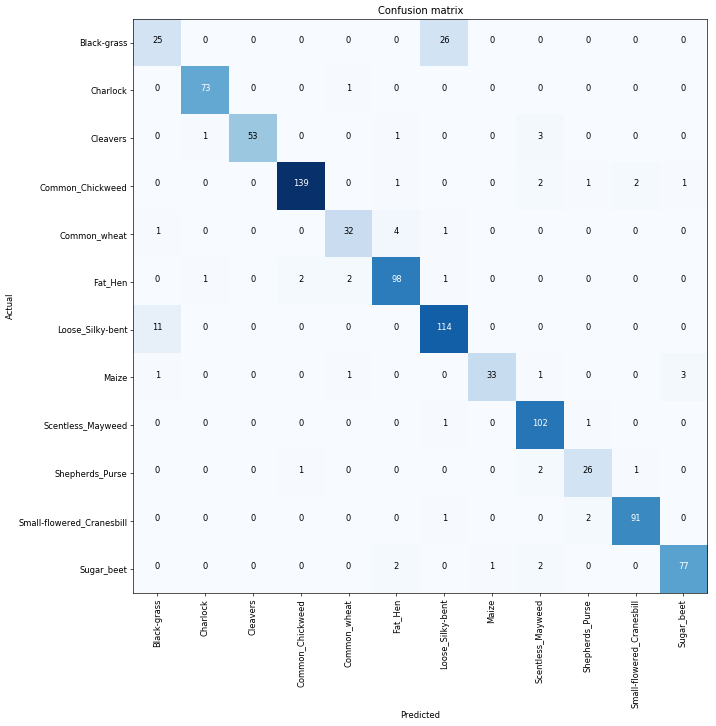

In [25]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [26]:
interp.most_confused(min_val=2)

[('Black-grass', 'Loose_Silky-bent', 26),
 ('Loose_Silky-bent', 'Black-grass', 11),
 ('Common_wheat', 'Fat_Hen', 4),
 ('Cleavers', 'Scentless_Mayweed', 3),
 ('Maize', 'Sugar_beet', 3)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(1)

Total time: 01:49
epoch  train_loss  valid_loss  error_rate
1      0.608486    0.332536    0.115344    (01:49)



In [29]:
# The result seems worse so we have to find the optimal learning rate
learn.load('stage-1-coursev3')

In [30]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


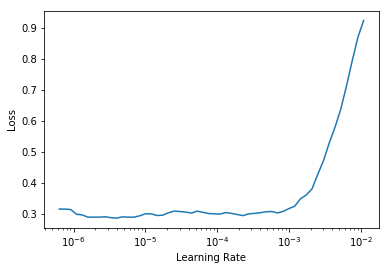

In [31]:
learn.recorder.plot()

In [32]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 03:39
epoch  train_loss  valid_loss  error_rate
1      0.285300    0.244222    0.077249    (01:48)
2      0.275478    0.236991    0.081481    (01:50)



That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here.

In [17]:
np.random.seed(2)
data = ImageDataBunch.from_csv(path=path_train, ds_tfms=get_transforms(), size=299, csv_labels=path_labels,test=path_test, bs =48 ) # larger size = 299
data.normalize(imagenet_stats)

In [18]:
learn = create_cnn(data, models.resnet50, metrics=error_rate )

In [19]:
learn.fit_one_cycle(5)

Total time: 12:01
epoch  train_loss  valid_loss  error_rate
1      1.156322    0.411806    0.141799    (02:31)
2      0.523106    0.260614    0.087831    (02:22)
3      0.320490    0.206861    0.069841    (02:21)
4      0.206868    0.170963    0.062434    (02:23)
5      0.145033    0.171594    0.050794    (02:23)



In [20]:
beep()

In [21]:
learn.save('stage-1-50-coursev3')

 Let's see if full fine-tuning helps:

In [24]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))

Total time: 12:19
epoch  train_loss  valid_loss  error_rate
1      0.112761    0.151503    0.050794    (02:26)
2      0.120524    0.153878    0.040212    (02:28)
3      0.097552    0.147373    0.042328    (02:27)
4      0.083420    0.142339    0.040212    (02:28)
5      0.078597    0.141231    0.040212    (02:28)



In this case it doesn't, so let's go back to our previous model.

In the fastai 0.7 the nb achieved error rat 0.051 , but with more cycles, so perhaps here too it needs more cycles

In [25]:
beep()

In [70]:
learn.save('stage-2-50-coursev3')

In [71]:
learn.load('stage-2-50-coursev3')

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

In [27]:
interp.most_confused(min_val=2)

[('Black-grass', 'Loose_Silky-bent', 11),
 ('Loose_Silky-bent', 'Black-grass', 6),
 ('Scentless_Mayweed', 'Shepherds_Purse', 3)]

## Create submission

In [28]:
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common_Chickweed',
 'Common_wheat',
 'Fat_Hen',
 'Loose_Silky-bent',
 'Maize',
 'Scentless_Mayweed',
 'Shepherds_Purse',
 'Small-flowered_Cranesbill',
 'Sugar_beet']

The kaggle required submission should use class names with ' ' spaces. I have replaced them with _ so that the fastai library does not regard it as multi-label classification task. Now I have to use again the same classes as required by kaggle

In [29]:
classes = [c.replace('_', ' ') for c in data.classes]

In [30]:
classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [31]:
log_preds_test, y_test = learn.TTA(is_test=True) # use test dataset rather than validation dataset


Total time: 02:25



In [32]:
# probs_test = np.mean(np.exp(log_preds_test),0) # in fastai it was log_pred_test was returning extra dimension = 5 which is the TTA images
probs_test = np.exp(log_preds_test)
#accuracy_np(probs_test, y_test), metrcs.log_loss(y_test, probs_test) # This does not make sense since test dataset has no labels

learn.TTA(is_test=True) is when we are making pred for test data, so there is no meaning for y_test which are the ground truth labels (all will be 0)

In [ ]:
beep()

In [33]:
y_test, y_test.shape 

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

In [34]:
log_preds_test.shape

torch.Size([794, 12])

In [35]:
probs_test.shape # (n_images, n_classes)

torch.Size([794, 12])

In [36]:
probs_test

tensor([[1.0000, 1.0001, 1.0020,  ..., 1.0000, 1.0000, 2.7098],
        [1.0028, 1.0007, 1.0019,  ..., 1.0000, 1.0000, 2.2712],
        [1.0000, 1.0001, 1.0000,  ..., 2.7163, 1.0000, 1.0000],
        ...,
        [1.5151, 1.0005, 1.0007,  ..., 1.0001, 1.0017, 1.0002],
        [1.0000, 1.0000, 1.0000,  ..., 1.0021, 1.0000, 1.0000],
        [1.0007, 1.0014, 1.0005,  ..., 1.0000, 1.0004, 1.0020]])

In [37]:
y_results = np.argmax(probs_test, axis=1)

In [38]:
y_results, y_results.shape

(tensor([11, 11,  9,  6,  1,  7,  4,  2,  5,  8,  7,  3,  6,  6, 11,  6,  8,  8,
          5, 10,  6,  9,  5,  3, 11, 11,  7,  7,  1,  6,  3,  0,  6,  0,  4,  6,
          5,  3,  6,  8, 10,  1, 11,  6,  1,  4,  5,  5,  7,  2,  8,  6, 11,  2,
         10,  6,  7,  7,  5,  6, 10,  0,  3, 10,  3, 11,  6,  1, 11, 10,  6,  7,
          3,  1,  6,  2,  5, 10,  8,  2,  6,  5, 10,  4,  8,  3,  3,  6,  9,  3,
          1,  3,  3,  8,  2, 11,  6,  6,  2, 11,  4,  3,  6,  6,  8,  6,  5,  6,
         10,  0, 11,  6, 10,  6,  5, 10,  6,  8,  4, 10,  5,  9,  7,  8, 11,  1,
         10,  7, 11,  8,  4,  9,  0, 10, 10,  2,  3, 10,  7,  1,  3,  1,  3,  0,
          9, 11,  6, 11,  6,  9,  3,  6,  3,  6,  6,  7, 10,  7,  5,  3, 11,  6,
          3,  7,  0,  4,  8,  9,  7,  9,  1,  8, 11,  7,  8,  6,  8,  9,  6,  7,
          8,  0,  2,  0,  8, 11,  5,  0,  8,  8,  6,  3,  3,  5,  4,  2, 11,  5,
          6,  2,  9,  3,  2,  2,  6,  6, 10,  1,  8,  9,  6,  8,  1,  1, 10,  2,
          8,  8,  9,  6,  4,

In [39]:
y_results_names = [classes[n] for n in y_results]

In [40]:
y_results_names

['Sugar beet',
 'Sugar beet',
 'Shepherds Purse',
 'Loose Silky-bent',
 'Charlock',
 'Maize',
 'Common wheat',
 'Cleavers',
 'Fat Hen',
 'Scentless Mayweed',
 'Maize',
 'Common Chickweed',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Sugar beet',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Fat Hen',
 'Small-flowered Cranesbill',
 'Loose Silky-bent',
 'Shepherds Purse',
 'Fat Hen',
 'Common Chickweed',
 'Sugar beet',
 'Sugar beet',
 'Maize',
 'Maize',
 'Charlock',
 'Loose Silky-bent',
 'Common Chickweed',
 'Black-grass',
 'Loose Silky-bent',
 'Black-grass',
 'Common wheat',
 'Loose Silky-bent',
 'Fat Hen',
 'Common Chickweed',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Small-flowered Cranesbill',
 'Charlock',
 'Sugar beet',
 'Loose Silky-bent',
 'Charlock',
 'Common wheat',
 'Fat Hen',
 'Fat Hen',
 'Maize',
 'Cleavers',
 'Scentless Mayweed',
 'Loose Silky-bent',
 'Sugar beet',
 'Cleavers',
 'Small-flowered Cranesbill',
 'Loose Silky-bent',
 'Maize',
 'Maize',
 'F

In [41]:
# df = pd.DataFrame(probs_test) #This was for the dog breeding competition
# df.columns = classes 
df = pd.DataFrame(y_results_names)
df.columns = ['species']

In [42]:
df.head()

,species
0,Sugar beet
1,Sugar beet
2,Shepherds Purse
3,Loose Silky-bent
4,Charlock


In [43]:
# data.test_ds.fnames[0], data.test_ds.fnames[0][5:]   # This was in fastai v0.7

# https://docs.python.org/3/library/pathlib.html for details about posixpath
data.test_ds.ds.x[0], data.test_ds.ds.x[0].parts[-1]


(PosixPath('/home/haider/.fastai/data/plant_seedlings/test/24dbc3b21.png'),
 '24dbc3b21.png')

In [44]:
df.insert(0, 'file', [o.parts[-1] for o in data.test_ds.ds.x])

In [45]:
df.head()

,file,species
0,24dbc3b21.png,Sugar beet
1,df11d56a7.png,Sugar beet
2,37714071b.png,Shepherds Purse
3,ef65533d5.png,Loose Silky-bent
4,efe19dc32.png,Charlock


In [46]:
path

PosixPath('/home/haider/.fastai/data/plant_seedlings')

In [47]:
SUBM = f'{path}/subm/'
os.makedirs(SUBM, exist_ok=True)
#df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)
df.to_csv(f'{SUBM}subm2.csv', index=False)

In [48]:
%%bash
ls /home/haider/.fastai/data/plant_seedlings/subm/


subm_1_ubt_fastai1.csv
subm2.csv
subm.csv


In [49]:
from IPython.display import FileLink
# Shift-right-clicking on the link opens the browser context menu
# FileLink(f'{SUBM}subm_1_ubt_fastai1.csv')
FileLink('/home/haider/.fastai/data/plant_seedlings/subm/subm_1_ubt_fastai1.csv')
# Downloading from absolute paths do not work. See: https://forums.fast.ai/t/filelink-will-not-work-for-absolute-paths/28712

/home/haider/.fastai/data/plant_seedlings/subm/subm_1_ubt_fastai1.csv

In [50]:
beep()

I got public rank of 355 with score 0.9659

## Individual prediction

In [51]:
fn = data.valid_ds.ds.x[0]
fn

'/home/haider/.fastai/data/plant_seedlings/train/0183fdf68.png'

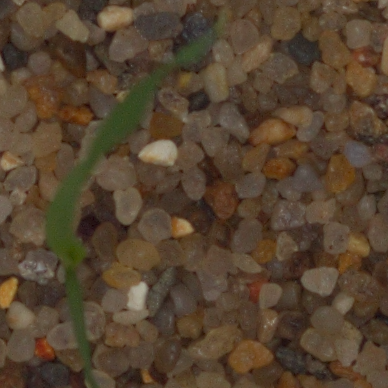

In [64]:
img = open_image(fn)
img

In [65]:
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common_Chickweed',
 'Common_wheat',
 'Fat_Hen',
 'Loose_Silky-bent',
 'Maize',
 'Scentless_Mayweed',
 'Shepherds_Purse',
 'Small-flowered_Cranesbill',
 'Sugar_beet']

In [75]:
classes = data.classes
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=299).normalize(imagenet_stats) 
# why is path needed in single_from_classes? 
# sguger: To know where the models is stored
learn = create_cnn(data2, models.resnet50)
learn.load('stage-2-50-coursev3')

In [76]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'Sugar_beet'

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Individual prediction from www as jpg format

In [80]:
fn = '/home/haider/.fastai/data/plant_seedlings/testing_from_www/russian_wheat.jpg'
fn

'/home/haider/.fastai/data/plant_seedlings/testing_from_www/russian_wheat.jpg'

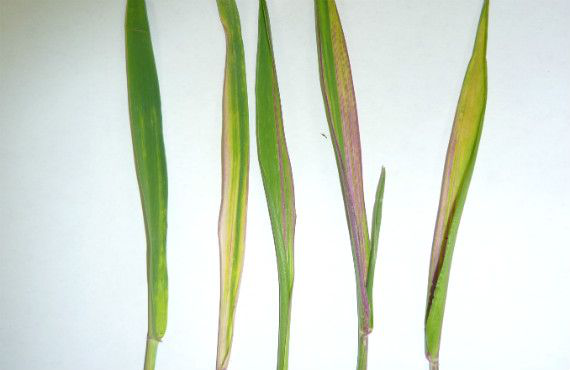

In [81]:
img = open_image(fn)
img

In [82]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'Sugar_beet'

In [83]:
fn = '/home/haider/.fastai/data/plant_seedlings/testing_from_www/com-chickweed-stem-big.jpg'
fn

'/home/haider/.fastai/data/plant_seedlings/testing_from_www/com-chickweed-stem-big.jpg'

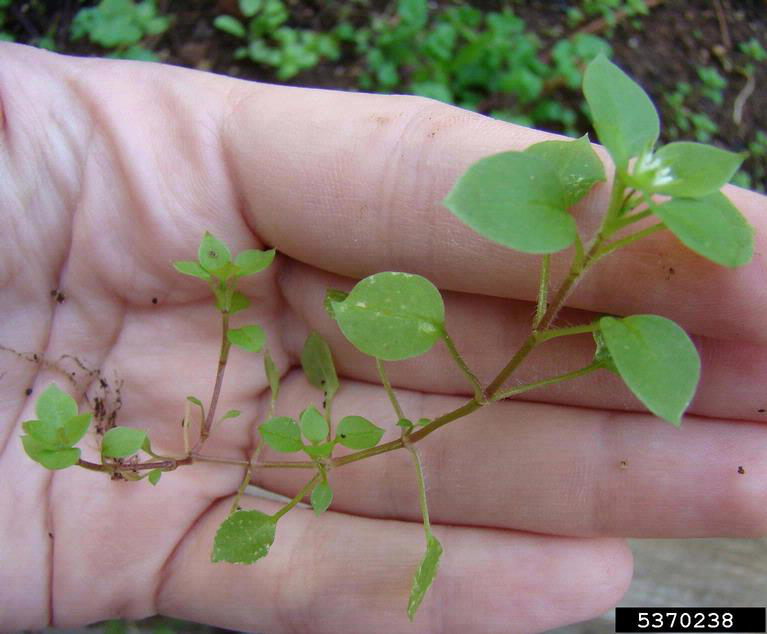

In [84]:
img = open_image(fn)
img

In [85]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'Scentless_Mayweed'

In [87]:
fn = '/home/haider/.fastai/data/plant_seedlings/testing_from_www/Chickweed-2-290x300.jpg'
img = open_image(fn)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class


'Sugar_beet'

In [88]:
fn = '/home/haider/.fastai/data/plant_seedlings/testing_from_www/cleeavers.jpg'
img = open_image(fn)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'Scentless_Mayweed'

In [89]:
fn = '/home/haider/.fastai/data/plant_seedlings/testing_from_www/B-Galium-aparine-aka-cleavers.jpg'
img = open_image(fn)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'Sugar_beet'

In [94]:
fn = '/home/haider/.fastai/data/plant_seedlings/testing_from_www/Small-flowered Cranesbill.jpg'
img = open_image(fn)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'Scentless_Mayweed'

In [95]:
fn = '/home/haider/.fastai/data/plant_seedlings/testing_from_www/Shepherds Purse.jpg'
img = open_image(fn)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'Scentless_Mayweed'

In [96]:
fn = '/home/haider/.fastai/data/plant_seedlings/testing_from_www/Shepherds Purse2.jpg'
img = open_image(fn)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'Sugar_beet'

In [97]:
fn = '/home/haider/.fastai/data/plant_seedlings/testing_from_www/MaizeLeaf.jpg'
img = open_image(fn)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'Sugar_beet'

### from the www no one predicted correct from the 10 files. Perhaps because of different normalization of the picture or different backgrounds ...etc.. 

The kaggle submission resulted in mean f score of 96% which means it is highly accurate. Obviously the dataset and test set of this competition is not reprasantative of the all picutres that we can take from www for these leaves. SO I think the model is overfit on the pictures of the guys who published this competiton. Just like what has been concluded for the imageNet that it is overfit on its own pictures.

## Testing prediction time for 1 image GPU vs CPU

In [17]:
fn = '/home/haider/.fastai/data/plant_seedlings/testing_from_www/russian_wheat.jpg'
fn

'/home/haider/.fastai/data/plant_seedlings/testing_from_www/russian_wheat.jpg'

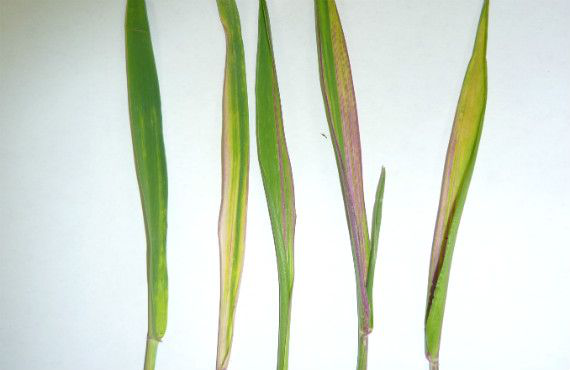

In [18]:
img = open_image(fn)
img

In [21]:
classes = ['Black-grass',
 'Charlock',
 'Cleavers',
 'Common_Chickweed',
 'Common_wheat',
 'Fat_Hen',
 'Loose_Silky-bent',
 'Maize',
 'Scentless_Mayweed',
 'Shepherds_Purse',
 'Small-flowered_Cranesbill',
 'Sugar_beet']

data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=299).normalize(imagenet_stats) 
# why is path needed in single_from_classes? 
# sguger: To know where the models is stored
learn = create_cnn(data2, models.resnet50)
learn.load('stage-2-50-coursev3')

In [23]:
%%time
pred_class,pred_idx,outputs = learn.predict(img)

CPU times: user 420 ms, sys: 360 ms, total: 779 ms
Wall time: 1.05 s


In [24]:
pred_class

'Sugar_beet'

#### GPU took 779 ms when run for the 1st time

In [25]:
fn = '/home/haider/.fastai/data/plant_seedlings/testing_from_www/Chickweed-2-290x300.jpg'
img = open_image(fn)


In [26]:
%%time
pred_class,pred_idx,outputs = learn.predict(img)

CPU times: user 102 ms, sys: 27.6 ms, total: 130 ms
Wall time: 85.2 ms


In [27]:
pred_class

'Sugar_beet'

#### GPU took 130 ms when run for the 2nd prediction for another image

Now I will return to the 1st image to predict and see its time

In [28]:
fn = '/home/haider/.fastai/data/plant_seedlings/testing_from_www/russian_wheat.jpg'
img = open_image(fn)

In [29]:
%%time
pred_class,pred_idx,outputs = learn.predict(img)

CPU times: user 86.6 ms, sys: 20.7 ms, total: 107 ms
Wall time: 82.9 ms


### CPU pred time

In [35]:
fastai.defaults.device = torch.device('cpu')

NameError: name 'fastai' is not defined

In [ ]:
, num_workers=4